# Wine Quaity DataSet Classification


## Data Set Information:

* Source: https://www.kaggle.com/rajyellow46/wine-quality

The dataset was downloaded from the UCI Machine Learning Repository.

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. The reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are munch more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

Two datasets were combined and few values were randomly removed.

## Data Set Information:

* For more information, read [Cortez et al., 2009].

### Input variables (based on physicochemical tests):
1 - fixed acidity  
2 - volatile acidity  
3 - citric acid  
4 - residual sugar  
5 - chlorides 
6 - free sulfur dioxide  
7 - total sulfur dioxide  
8 - density   
9 - pH  
10 - sulphates  
11 - alcohol 

### Output variable (based on sensory data):
12 - quality (score between 0 and 10)

Acknowledgements:

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

# The summary of analysis:


## Aim/Purpose

* The idea is create a machine learning model to:
    - Data Exploration/Visualization
        - Understand structure of the data.
    - Predict the quality of wine based on 11 inputs.
    - Determine factors which have the higher probability to predict the quality.
        - Reduce the dimension of variables. (Feature engineering)
    - Determine machine learning model for best classifying the wines.
    
    
## The flaw of analysis:

* We missed out problem dealing with imbalanced class.
    - There's more normal quality wines than poor/exellent ones.
    - Can be done with SMOTE (Synthetic Minority Oversampling Technique)
    - Reference: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
    - Add in another algorithm to oversample minority classs by duplication.

## Data Exploration:

* The charts are in the notebook.
* Found mainly three variables affecting the result of predicting outcomes:
    - Alcohol (Positive correlation with quality)
    - Sulphates (Positive correlation with quality)
    - Volatile Acidity (Negaitve correlation with quality)
    

## Model:

* We used **XGboost algorithm**
* Also we tried out several different algorithm such as CART and random forest.
* Reference: https://xgboost.readthedocs.io/en/latest/tutorials/model.html

### Explanation
* XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. This is a tutorial on gradient boosted trees, and most of the content is based on https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf by Tianqi Chen, the original author of XGBoost.
* One of the **supervised learning algorithm**.
* The boosted tree model is constructed, sequentially where each new tree attempts to model and correct for the errors made by the sequence of previous trees.
* Quickly, the model reaches a point of diminishing returns.

### Advantage:

* https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
* 1. Regularization:
    - Mathematically, machine learning model includes an **objective function** comprised of loss(Mean Square Error) + penalty regularization term, optimizing by reducing the objetive function.
    - It introduces a cost term for bringing in more features with the objective function. 
    - Hence, it tries to push the coefficients for many variables to zero and hence reduce cost term.
    - **Reference:**: https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c
    - L1 regulartization: Lasso Regression
        - Absolute magnitude of coefficients of variables.
    - L2 regulartization: Ridge Regression
        - Squared magnitude of coefficients of variables.
        
* 2. Parallel Processing:
    - XGBoost implements parallel processing and is blazingly faster as compared to GBM.
    
* 3. High Flexibility
    - Customization on optimization objectives and evaluation criteria.
    
* 4. Handling Missing Values
    - XGBoost has an in-built routine to handle missing values.
     
* 5. Tree Pruning:
    - A GBM would stop splitting a node when it encounters a negative loss in the split. 
    - XGBoost on the other hand make splits upto the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain.
    
* 6. Built-in Cross-Validation

* 7. Continue on Existing Model
     - User can start training an XGBoost model from its last iteration of previous run. 
     - This can be of significant advantage in certain specific applications.    
       

### Main parameters:
* **Reference**: https://xgboost.readthedocs.io/en/latest/parameter.html
* 1. Learning Rate:
    - Variable: **learning_rate**
    - Prevent overfitting.
    - Slow down the learning in the gradient boosting model is to apply a weighting factor for the corrections by new trees when added to the model.
     
* 2. Number of Trees:
    - Variable: **n_estimators**.
    - Optimize the number of trees will be efficiently improve training time, as the loss function could be capped for further increase of trees.
    
* 3. Depth of Trees:
    - Variable: **max_depth**.
    - Shallow trees are expected to have poor performance because they capture few details of the problem and are generally referred to as weak learners.
    - Deeper trees generally capture too many details of the problem and overfit the training dataset, limiting the ability to make good predictions on new data.
    - Pruning of trees basically in short.
    
* 4. Minimum sum of instance weight (hessian) needed in a child. 
    - Variable: **min_child_weight**.
    - **If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning**. 
    - In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. 
    - The larger min_child_weight is, the more conservative the algorithm will be.
      
* 5. Gamma
    - Variable: **gamma**
    - Minimum loss reduction required to make a further partition on a leaf node of the tree. 
    - The larger gamma is, the more conservative the algorithm will be.
    
* 6. Subsample of trees:
    - Variable: **subsample**
    - Subsample ratio (Rows of data) of the training instances. 
    - Prevent overfitting.
    - Occur once in every boosting iteration.
* 7. Objective:
    - Variable: **objective**
    - Specify the learning task and the corresponding learning objective. 
    - Mainly, for two class classification: 
        - **binary:logistic**
    - And for multiple class classification:
        - **multi:softmax**

In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from yellowbrick.classifier import ClassPredictionError, ROCAUC


import numpy as np
import pandas as pd
import matplotlib
import plotly.figure_factory as ff
import plotly.graph_objects as go
import scipy
import shap
import squarify
import seaborn as sns
import xgboost as xgb

shap.initjs()
np.random.seed(0)


In [3]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")

In [4]:
dr_workplace = '/Users/mosesang/Documents/machine learning python/kaggle_winequality/'
df = pd.read_csv(dr_workplace + '/winequality-red.csv') # Load the data

In [5]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


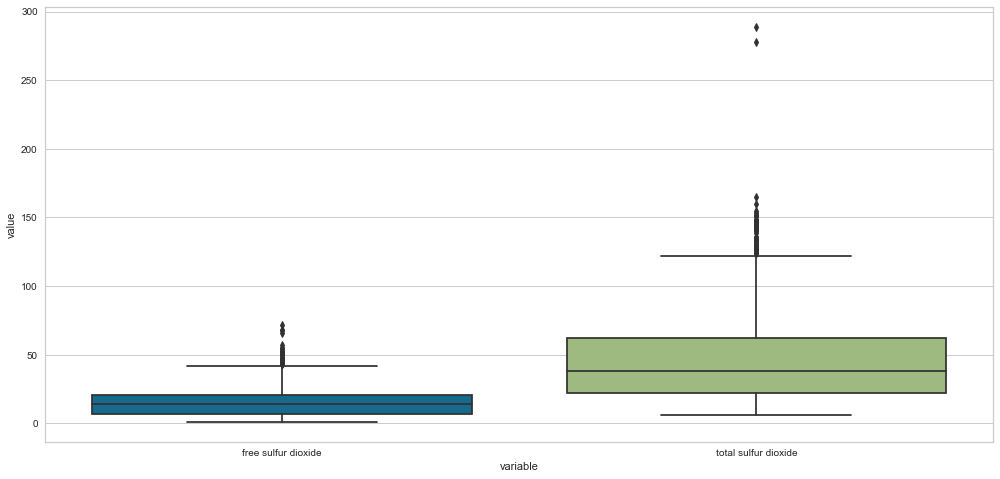

In [6]:
# Split due to unscaled value. (We could normalize but let's check the raws one.)
plt.figure(figsize=(17,8))
df_fil = pd.melt(df)
ignore_list = ['free sulfur dioxide', 'total sulfur dioxide']
df_fil = df_fil[df_fil['variable'].isin(ignore_list)]
boxplot_df = sns.boxplot(x = "variable", y = "value", data = df_fil)

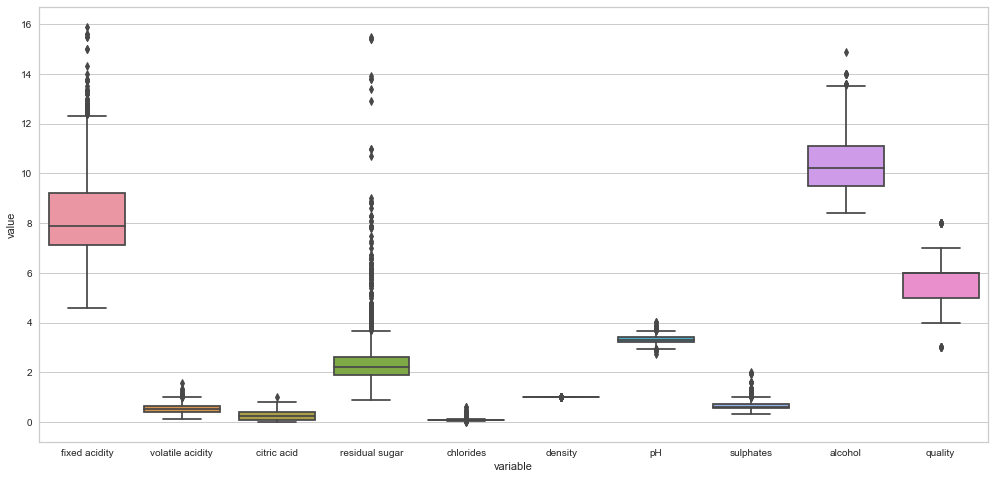

In [7]:
# Boxplot of most variables
plt.figure(figsize=(17,8))
df_fil = pd.melt(df)
ignore_list = ['free sulfur dioxide', 'total sulfur dioxide']
df_fil = df_fil[~df_fil['variable'].isin(ignore_list)]
boxplot_df = sns.boxplot(x = "variable", y = "value", data = df_fil)

In [8]:
# The target variable is 'quality'.
feature_names = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar','chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']
y = df['quality']
X = df[feature_names]
# Split the data into train and test data:
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size = 0.05)
#X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.05)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)
#X_test = X_test[X_train.columns]

#dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = feature_names)
#dtest = xgb.DMatrix(X_test, label = y_test, feature_names = feature_names)


#X_train = X_train.as_matrix()
#X_test  = X_test.as_matrix()

In [9]:
xgb = XGBClassifier()
logreg2 = LogisticRegressionCV()
knn = KNeighborsClassifier()
svcl = SVC()
adb = AdaBoostClassifier()
dtclf = DecisionTreeClassifier()
rfclf = RandomForestClassifier()

#Prepare the config for cross validation test harness
seed = 100

#Prepare the model
models = []
#models.append(('LR-lbfgs', LogisticRegressionCV(solver = 'lbfgs', max_iter = 5000, cv = 10, multi_class = 'auto')))
models.append(('LR-liblinear', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('XGB', XGBClassifier()))
models.append(('KNN', KNeighborsClassifier(5)))
models.append(('DT', DecisionTreeClassifier(max_depth = 5))) #Inludes pruning at 5
models.append(('RF', RandomForestClassifier(max_depth = 6, random_state=0, n_estimators=10)))
models.append(('ADA', AdaBoostClassifier()))
#models.append(('NB', GaussianNB()))
models.append(('SVC-scale', SVC(gamma = 'scale')))
models.append(('Neural Network', MLPClassifier(solver='lbfgs', alpha=1e-5,
                                               hidden_layer_sizes=(5, 2), random_state = 0)))
#models.append(('SVC-auto', SVC(gamma='auto')))

#Evaluate each model
results = []
names = []
for name, model, in models:
    kfold = StratifiedKFold(n_splits = 10, random_state = seed)
    cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR-liblinear: 0.582606 (0.026832)
LDA: 0.593128 (0.019885)
XGB: 0.636658 (0.032454)
KNN: 0.500326 (0.037891)
DT: 0.587366 (0.047978)
RF: 0.624284 (0.035042)
ADA: 0.522709 (0.092203)
SVC-scale: 0.505608 (0.039356)
Neural Network: 0.426611 (0.002014)


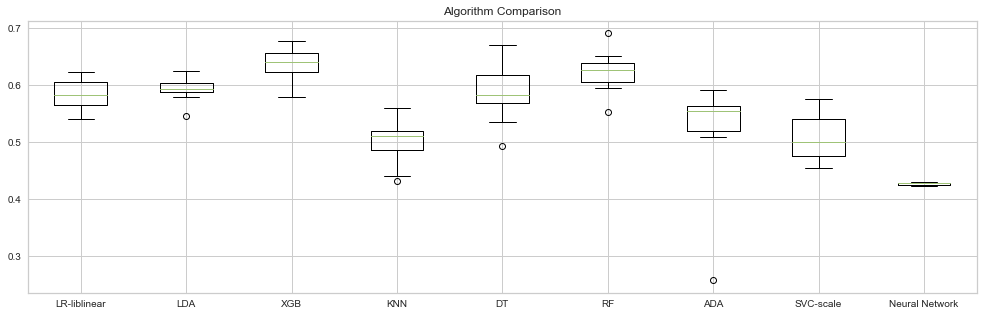

In [10]:
# Compare Algorithms
plt.figure(figsize=(17,5))
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

# Overall all the algorithm provides a good picture, with accuracy >60%
# Looks like XGB gives the highest accuracy and lower sd, then RF.

In [15]:
#Primary hyperparameters tuning for XGBoost

param_test_obj = {
    'objective':["multi:softprob", "binary:logistic", "multi:softmax"]
}

gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=8,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test_obj, n_jobs=4, iid=False, cv=10)

gsearch.fit(X_train, y_train)
#gsearch4.cv_results_, 
gsearch.best_params_, gsearch.best_score_



({'objective': 'multi:softprob'}, 0.6912989688837653)

In [ ]:
#1st Hyperparameters tuning for XGBoost

param_test1 = {
    'max_depth':range(2, 12, 1),
    'min_child_weight':range(1, 12, 1)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth = 8,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, n_jobs=4, iid=False, cv=10)

gsearch1.fit(X_train, y_train)
#gsearch1.cv_results_, 
gsearch1.best_params_, gsearch1.best_score_

In [19]:
#2nd Hyperparameters tuning for XGBoost

param_test2 = {
    'gamma':np.arange(0, 1, 0.1)
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=11,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test2, n_jobs=4, iid=False, cv=10)

gsearch2.fit(X_train, y_train)
#gsearch2.cv_results_, 
gsearch2.best_params_, gsearch2.best_score_



({'gamma': 0.0}, 0.6774063805585)

In [17]:
#3rd Hyperparameters tuning for XGBoost

param_test3 = {
    'subsample':np.arange(0, 1, 0.1),
    'colsample_bytree':np.arange(0, 1, 0.1)
}

gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=11,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test3 ,n_jobs=4, iid=False, cv=10)

gsearch3.fit(X_train, y_train)
#gsearch3.cv_results_, 
gsearch3.best_params_, gsearch3.best_score_



({'colsample_bytree': 0.4, 'subsample': 0.9}, 0.68926211286589)

In [13]:
# Make predictions on validation dataset
model = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=11,
                      min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.4,
                      objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27,n_jobs=4, 
                      siid=False, cv=5)

model.fit(X_train, y_train)
predictions = model.predict(X_test)


# Evaluate predictions
print('Accuracy of XBG Classifier Model on test set: {:.2%}'
     .format(accuracy_score(y_test, predictions)))
print('*' * 60)
print('Confusion Matrix')
print(confusion_matrix(y_test, predictions))
print('*' * 60)
print('Classification Report')
print(classification_report(y_test, predictions))

# XGB gives 92.25% accuracy in predicting the CLVCluster after 7 months.
# Extra tuning maybe be needed if we wish to achieve higher accuracy!
#https://stackabuse.com/understanding-roc-curves-with-python/

Accuracy of XBG Classifier Model on test set: 75.00%
************************************************************
Confusion Matrix
[[ 0  2  2  0]
 [ 0 28  5  0]
 [ 0  5 27  3]
 [ 0  0  3  5]]
************************************************************
Classification Report
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         4
           5       0.80      0.85      0.82        33
           6       0.73      0.77      0.75        35
           7       0.62      0.62      0.62         8

    accuracy                           0.75        80
   macro avg       0.54      0.56      0.55        80
weighted avg       0.71      0.75      0.73        80



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.


In [23]:
# The model has been defined as xgboost model in previous tab.
# Create Shap Explainer for train and test dataset:
model = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=11,
                      min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.4,
                      objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27,n_jobs=4, 
                      siid=False, cv=5)

model.fit(X_train, y_train)

X_test_ = pd.DataFrame(X_test, columns = feature_names)
test_explainer  = shap.KernelExplainer(model.predict, X_test_)
test_shap_values  = test_explainer.shap_values(X_test_)

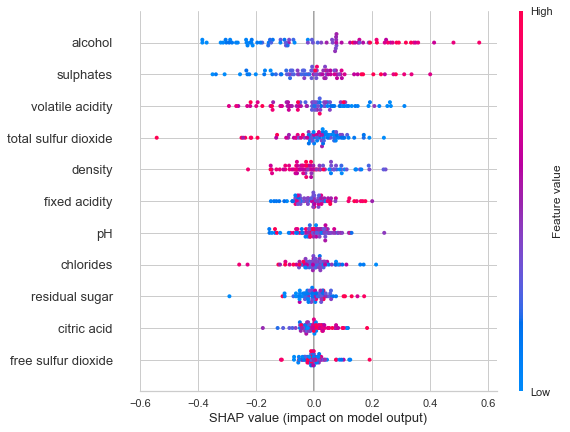

In [24]:
#Plot test dataset only due to huge dataset.
shap.summary_plot(test_shap_values, X_test_, plot_size = 0.5)

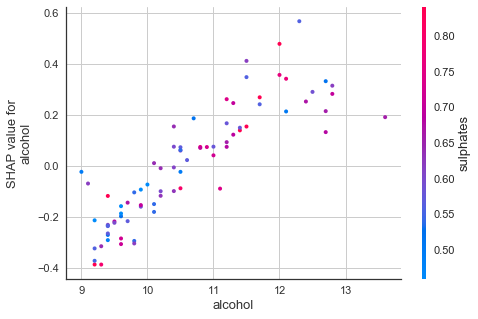

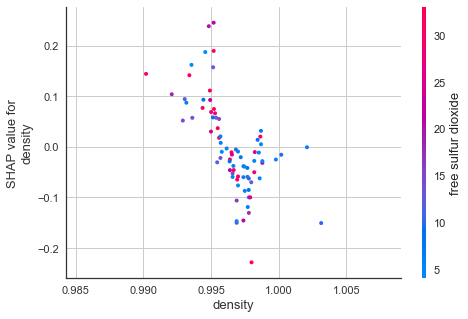

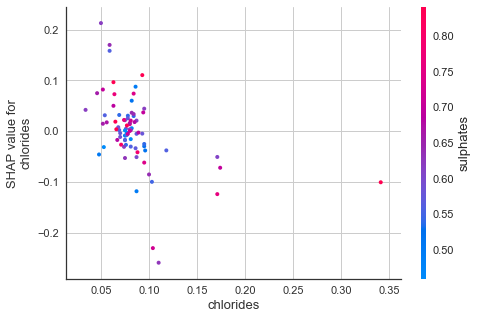

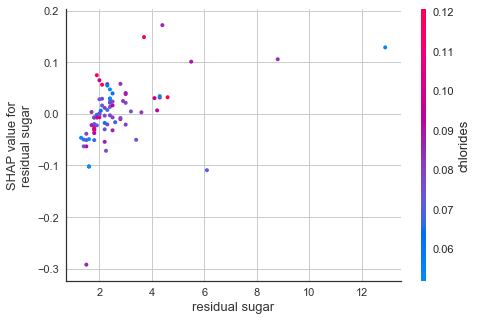

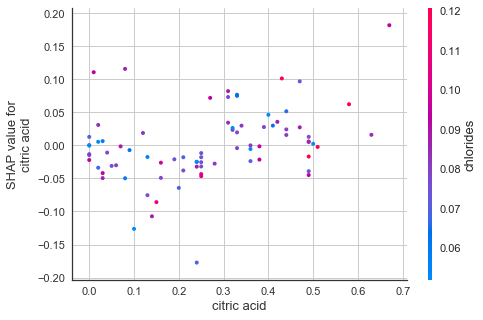

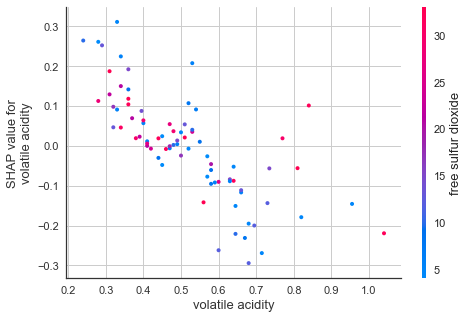

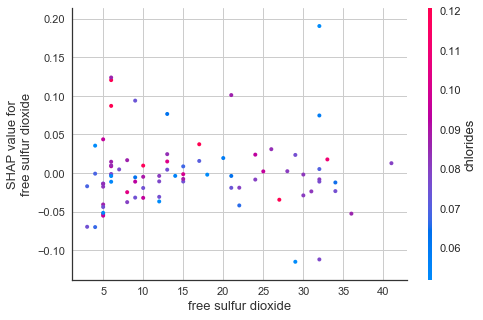

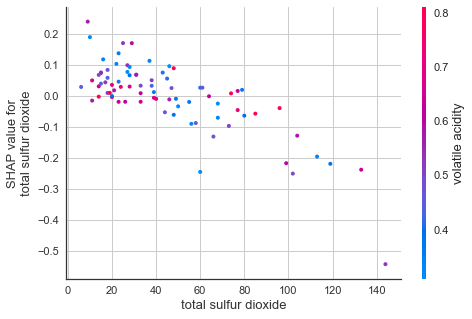

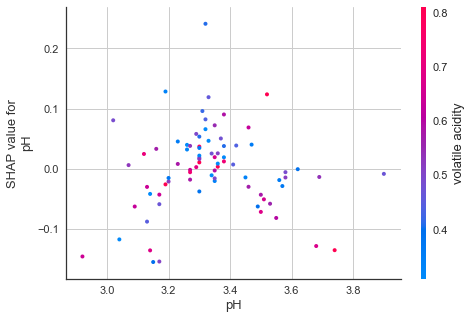

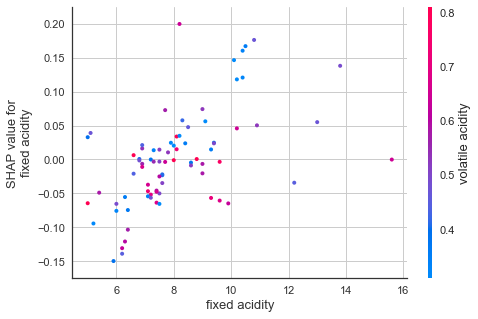

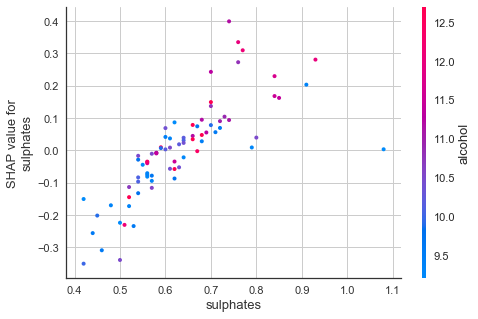

In [25]:
avg_feature = pd.DataFrame(test_shap_values, columns = feature_names).mean()
avg_feature = pd.DataFrame(avg_feature.sort_values(ascending = False)).index
for fn in avg_feature:
    shap.dependence_plot(fn, test_shap_values, X_test_)

In [26]:
# plot the SHAP values for the 10th observation 
shap.force_plot(test_explainer.expected_value, test_shap_values[10,:], X_test_.iloc[10,:])

In [27]:
#The collective force plot
shap.force_plot(test_explainer.expected_value, test_shap_values, X_test_)

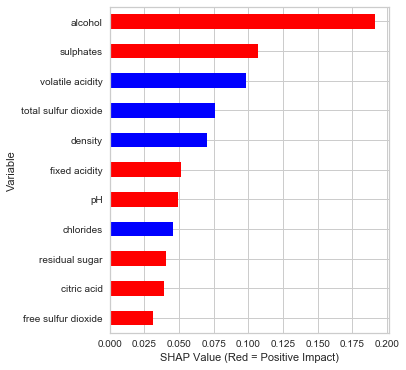

In [29]:
ABS_SHAP(test_shap_values, X_test_)